# Try to simulate Airy's rings

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))

In [3]:
import batoid
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from scipy.ndimage import rotate
from scipy.signal import fftconvolve

from ghost_buster import display_image as display
from ghost_buster import sources_image as sim
from ghost_buster import ghosts_corr as gcorr
from ghost_buster import ghosts_fit as gfit
from ghost_buster import ghosts_simu as gsim

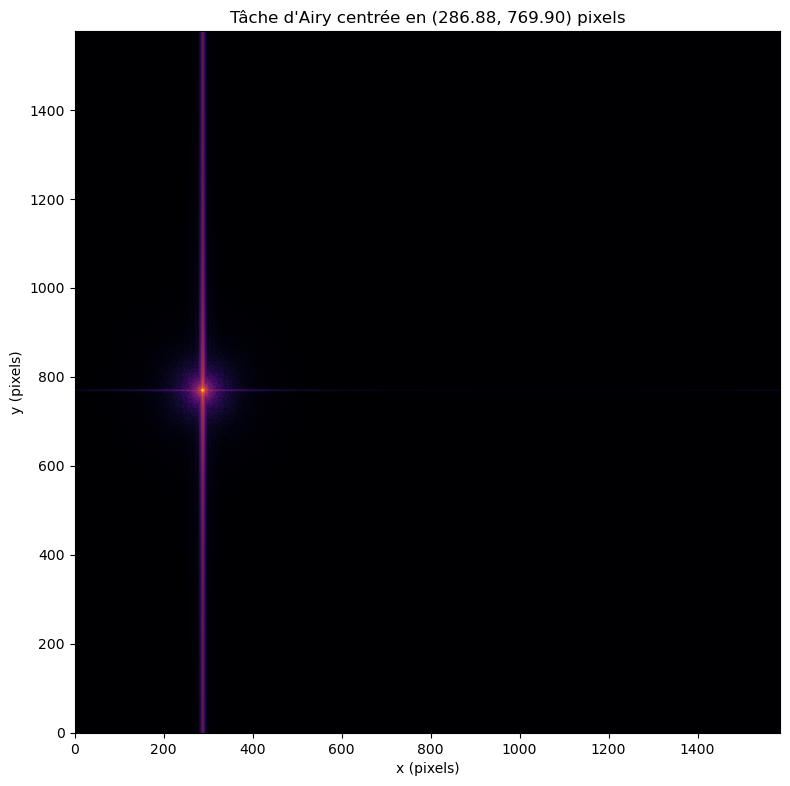

In [18]:
# --- Paramètres physiques (données LSSTCam) ---
binning = 8.0
wavelength = 622.2e-9  # m
D=8.36
f=9.8648

theta = 1.22 * lambda_ / D
rayon_image_m = f * theta


# --- Taille de l'image ---
Ny, Nx = 1577, 1586      # Taille de l'image en pixels
pixel_scale_arcsec = 0.2*binning  # 0.2 arcsec/pixel
pixel_scale_rad = pixel_scale_arcsec * np.pi / (180 * 3600)
pixel_scale_m = f * pixel_scale_rad  # Conversion en m/pixel

# Calcul du champ de vue
FOV_x = Nx * pixel_scale_m
FOV_y = Ny * pixel_scale_m

# --- Coordonnées dans le plan image ---
x = np.linspace(-FOV_x / 2, FOV_x / 2, Nx)
y = np.linspace(-FOV_y / 2, FOV_y / 2, Ny)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

# --- Motif d’Airy ---
k = 2 * np.pi / wavelength
alpha = k * D * R / (2 * f) + 1e-20  # éviter division par zéro
airy = (2 * j1(alpha) / alpha)**2
airy /= airy.max()

# --- Position de l’étoile en pixels ---
x_star = 286.87692047715433
y_star = 769.9001264140228

# --- Décalage sous-pixel via FFT ---
def fourier_shift(image, dx, dy):
    ny, nx = image.shape
    fx = np.fft.fftfreq(nx)
    fy = np.fft.fftfreq(ny)
    FX, FY = np.meshgrid(fx, fy)
    shift_phase = np.exp(-2j * np.pi * (FX * dx + FY * dy))
    f_image = np.fft.fft2(image)
    f_shifted = f_image * shift_phase
    return np.abs(np.fft.ifft2(f_shifted))

# Calcul du shift
shift_x = x_star - Nx / 2.0
shift_y = y_star - Ny / 2.0

# Appliquer le décalage
image = fourier_shift(airy, shift_x, shift_y)

# --- Affichage ---
plt.figure(figsize=(8, 8))
plt.imshow(np.log10(image + 1e-6), cmap='inferno',
           extent=[0, Nx, 0, Ny], origin='lower')
plt.title(f"Tâche d'Airy centrée en ({x_star:.2f}, {y_star:.2f}) pixels")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
#plt.colorbar(label="log10(Intensité relative)")
plt.savefig('Airy', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [14]:
def getAiry(xstar, ystar, rot, D=8.36, f=9.8648):
    binning = 8.0
    wavelength = 666e-9  # m
    
    theta = 1.20 * wavelength / D
    rayon_image_m = f * theta
    
    Ny, Nx = 1577, 1586
    pixel_scale_arcsec = 0.2*binning
    pixel_scale_rad = pixel_scale_arcsec * np.pi / (180 * 3600)
    pixel_scale_m = f * pixel_scale_rad
    
    FOV_x = Nx * pixel_scale_m
    FOV_y = Ny * pixel_scale_m
    
    x = np.linspace(-FOV_x / 2, FOV_x / 2, Nx)
    y = np.linspace(-FOV_y / 2, FOV_y / 2, Ny)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    
    k = 2 * np.pi / wavelength
    alpha = k * D * R / (2 * f)
    airy = (2 * j1(alpha) / alpha)**2
    airy = airy/airy.max()
    airy_rotated = rotate(airy, angle=rot, reshape=False, order=3)
    
    def fourier_shift(image, dx, dy):
        ny, nx = image.shape
        fx = np.fft.fftfreq(nx)
        fy = np.fft.fftfreq(ny)
        FX, FY = np.meshgrid(fx, fy)
        shift_phase = np.exp(-2j * np.pi * (FX * dx + FY * dy))
        f_image = np.fft.fft2(image)
        f_shifted = f_image * shift_phase
        return np.abs(np.fft.ifft2(f_shifted))

    shift_x = xstar - Nx / 2.0
    shift_y = ystar - Ny / 2.0
    
    image = fourier_shift(airy_rotated, shift_x, shift_y)

    theta_x = shift_x * pixel_scale_arcsec / 3600.0
    theta_y = shift_y * pixel_scale_arcsec / 3600.0
    psf_norm = psfNorm(theta_x, theta_y)
    
    image_psf = fftconvolve(image, psf_norm, mode='same')
    image_psf = image_psf/image_psf.max()
    
    return image_psf

def psfNorm(theta_x, theta_y):
    target_Ny, target_Nx = 1577, 1586
    nx = max(target_Ny, target_Nx)

    telescope = gsim.initTelescope()
    wavelength = 622.2e-9

    fftpsf = batoid.fftPSF(
        telescope,
        np.deg2rad(theta_x), np.deg2rad(theta_y),
        wavelength,
        nx=nx,
        pad_factor=1
    )

    psf = fftpsf.array
    psf = psf / psf.sum()

    # Rognage central (crop) si trop grand
    start_y = (psf.shape[0] - target_Ny) // 2
    start_x = (psf.shape[1] - target_Nx) // 2
    psf_cropped = psf[start_y:start_y+target_Ny, start_x:start_x+target_Nx]
    psf_cropped = psf_cropped / psf_cropped.sum()

    return psf_cropped

In [20]:
airy = getAiry(286.87692047715433, 769.9001264140228, -77.89209882814671)

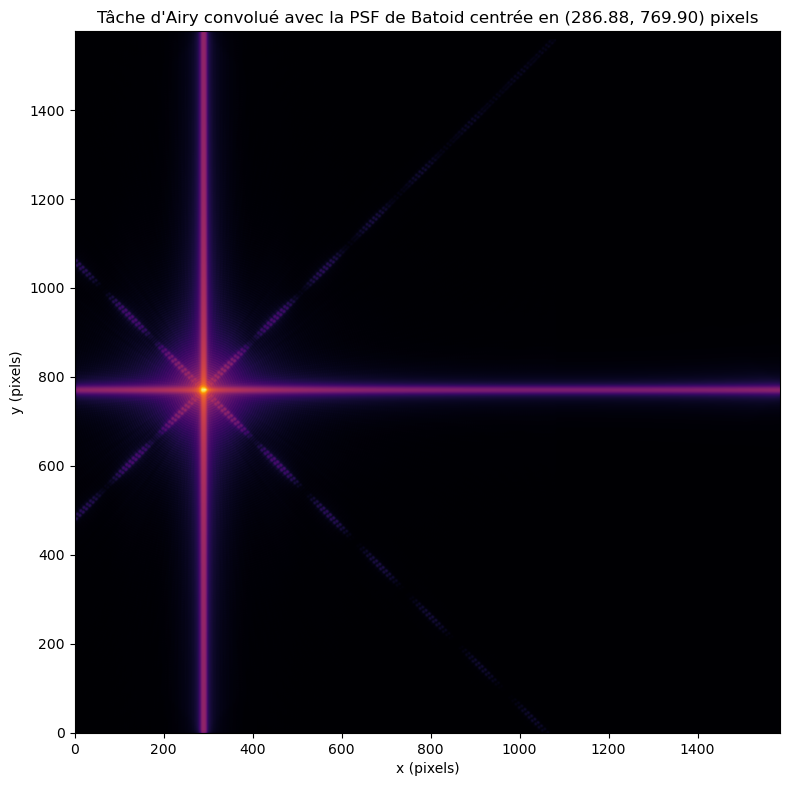

In [21]:
plt.figure(figsize=(8, 8))
plt.imshow(np.log10(airy + 1e-6), cmap='inferno',
           extent=[0, Nx, 0, Ny], origin='lower')
plt.title(f"Tâche d'Airy convolué avec la PSF de Batoid centrée en ({x_star:.2f}, {y_star:.2f}) pixels")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
#plt.colorbar(label="log10(Intensité relative)")
plt.tight_layout()
plt.savefig('AiryPsf', bbox_inches='tight')
plt.show()